# RadQG Demo
In this notebook, we will demonstrate the main functionalities of the RadQG project in a notebook environment. To work with the GUI application, please run the `app.py` file.

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
import skimage.io as io
import radqg.configs as configs
from radqg.generator import Generator
from radqg.llm.openai import embed_fn as openai_embed_fn
from radqg.llm.openai import qa as openai_qa

### Extracting the figures and text from HTML files 

Please download your desired articles from the RadioGraphics website as HTML files and put them in the toy_data_dir folder. Do not change the names of the files and folders when saving them from the website. Five sample articles are already provided.

In [2]:
# Listing all the HTML files

toy_data_dir = configs.TOY_DATA_DIR

print("Name of the articles: \n")
for file in os.listdir(toy_data_dir):
    if file.endswith(".html"):
        print(file)

Name of the articles: 

Peritoneal and Retroperitoneal Anatomy and Its Relevance for Cross-Sectional Imaging _ RadioGraphics.html
Gastrointestinal Tract Dilatations_ Why and How They Happen—A Simplified Imaging Classification _ RadioGraphics.html
Cross-sectional Imaging of the Duodenum_ Spectrum of Disease _ RadioGraphics.html
Internal Hernias in the Era of Multidetector CT_ Correlation of Imaging and Surgical Findings _ RadioGraphics.html
Role of Multimodality Imaging in Gastroesophageal Reflux Disease and Its Complications, with Clinical and Pathologic Correlation _ RadioGraphics.html
Imaging of Drug-induced Complications in the Gastrointestinal System _ RadioGraphics.html
Murphy’s Law_ What Can Go Wrong in the Gallbladder_ Resident and Fellow Education Feature _ RadioGraphics.html
Pearls and Pitfalls in Multimodality Imaging of Colonic Volvulus _ RadioGraphics.html
CT Findings of Acute Small-Bowel Entities _ RadioGraphics.html
Surgical Approach to Gastroesophageal Reflux Disease_ Wh

### Create a QA generator

Creating the QA generator is the first step in the pipeline. In addition to the path to the directory containing the HTML files, we need to specify an embedding function (e.g., from OpenAI), and the chunk_size and chunk_overlap values that should be used for splitting the articles into chunks. The latter two could be changed in the notebook or in the `config.py` file.

The next step is to setup the generator. This step will return all the article names, paths to figures detected for the articles, their captions, and also a Python sampler for selecting random figures as the source for question generation. The user can specify a word or phrase as the interested `topic` when setting up the question bank for the generator. If provided, then the QA generator will be more inclined to select figures as the source for question genenration that have haptions related to the topic. Otherwise, the generator will pick completely random figures for question generation.

In [3]:
# Setting up the generator

generator = Generator(
    data_dir=toy_data_dir,
    embed_fn=openai_embed_fn,
    chunk_size=configs.CHUNK_SIZE,
    chunk_overlap=configs.CHUNK_OVERLAP,
)

topic = None
article_names, figpaths, captions, sampler = generator.setup_qbank(topic)

The collection "20231102_214221" has been created with:
    228 figures from 10 articles


### Figure selection
The next step is selecting a random figure. When the figure is selected, the name of the article containing the figure, the path to the figure, and the caption of the figure will be returned.

In [4]:
article_name, figpath, caption = generator.select_figure(
    article_names, figpaths, captions, sampler, reset_memory=False
)
print("Article name: ", article_name)
print("Figure path: ", figpath)
print("Caption: ", caption)

Article name:  Internal Hernias in the Era of Multidetector CT_ Correlation of Imaging and Surgical Findings _ RadioGraphics.html
Figure path:  /research/projects/m221279_Pouria/RadQG/data/html_articles/Internal Hernias in the Era of Multidetector CT_ Correlation of Imaging and Surgical Findings _ RadioGraphics_files/images_medium_rg.2016150113.fig6.gif
Caption:  Figure 6.Incidentally diagnosed left paraduodenal hernia in a 54-year-old man with no symptoms. Axial contrast-enhanced CT image obtained for examination of liver cirrhosis shows a saclike mass (arrowheads) posterior to and left of the inferior mesenteric vein (arrow). Surgery was not performed.


#### Generate a question

The final step is to generate the question. The user should specify a question/answering function (e.g., from OpenAI), the name of the article containing the figure, and the caption of the figure. The question/answering function will return a Python dictionary containing the question and an answer to the questio. Optionally, the generator could also return a subset of the article text (referred to as `context`) that was extracted from the article and the LLM used it for developing a better question from the figure.
> Note: The type_of_question could be one of ["MCQ", "Short-Answer", "Long-Answer"].

Question: A 54-year-old man with liver cirrhosis is incidentally found to have a saclike mass on an axial contrast-enhanced CT image during routine examination. The patient is asymptomatic and no surgery is performed. Based on the figure provided, which of the following statements would be the most accurate?
Options: A) This condition is likely a right paraduodenal hernia
B) The condition is caused by failure of the ascending mesocolon to fuse with the posterior parietal peritoneum
C) The mass is likely to be in the fossa of Waldeyer
D) The inferior mesenteric vein is likely to be observed posterior and lateral to the hernia orifice and entrapped intestine
E) The condition is likely a left paraduodenal hernia
Answer: E) The condition is likely a left paraduodenal hernia. The saclike mass is located left of the inferior mesenteric vein, which is characteristic of a left paraduodenal hernia. These hernias are entrapments of the small intestine into the fossa of Landzert, an unusual conge

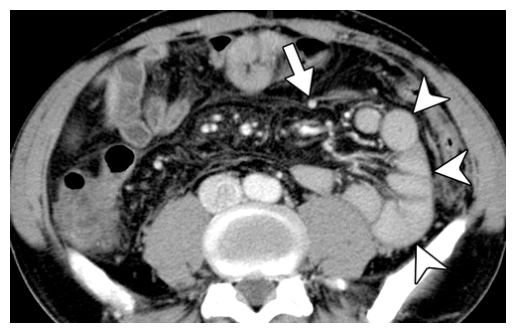

In [5]:
qa_dict, *logs = generator.generate_qa(
    qa_fn=openai_qa,
    article_name=article_name,
    figpath=figpath,
    caption=caption,
    type_of_question="MCQ",
    complete_return=True,
)

figure = io.imread(figpath).squeeze()
plt.imshow(figure)
plt.axis("off")
print(f"Question: {qa_dict['question']}")
if "options" in qa_dict:
    print(f"Options:\n{qa_dict['options']}")
print(f"Answer: {qa_dict['answer']}")

In [6]:
# Printing the logs will give you the following information:
# - Response generated from the first LLM (QA generator)
# - Response generated from the second LLM (Question modifier)
# - Response generated from the third LLM (Python dictionary generator)
# - The context used for the first LLM
# - Total number of tokens used (except for the embedding model)
# - Total dollars spent (except for the embedding model)

logs

["{'question': 'A 54-year-old man with liver cirrhosis is incidentally found to have a saclike mass on an axial contrast-enhanced CT image during routine examination. The mass is located posterior to and left of the inferior mesenteric vein. The patient is asymptomatic and no surgery is performed. Based on these findings, which of the following statements would be the most accurate?', 'options': 'A) This condition is likely a right paraduodenal hernia\\nB) The condition is caused by failure of the ascending mesocolon to fuse with the posterior parietal peritoneum\\nC) The mass is likely to be in the fossa of Waldeyer\\nD) The inferior mesenteric vein is likely to be observed posterior and lateral to the hernia orifice and entrapped intestine\\nE) The condition is likely a left paraduodenal hernia', 'answer': 'E) The condition is likely a left paraduodenal hernia. The saclike mass is located left of the inferior mesenteric vein, which is characteristic of a left paraduodenal hernia. The